# Assign RegulatoryOverlayUUIDs Values to Water Right sites.csv
Purpose:  To assign RegulatoryOverlayUUIDs values to state water right sites.csv File.

Notes: 
- requires the completed pre-processed sites.csv & watersource.csv files from the state "WaterAllocation/ProcessedInputData" folder to be copied over to the "Regulatory/ProcessedInputData" folder.  Rename to wr_sites.csv & wr_watersource.csv to preserve inputs.
- requires awareness of unique WaterSourceTypeCV of each water right site match up to corresponding WaterSourceTypeCV of regulatoryoverlays per reportingunits

In [1]:
# Needed Libraries / Modules

# ---- working with data ----
import os  # native operating system interaction
import numpy as np  # mathematical array manipulation
import pandas as pd  # data structure and data analysis
import geopandas as gpd  # geo-data structure and data analysis

# ---- visualization ----
import matplotlib.pyplot as plt  # plotting library
import seaborn as sns  # plotting library
import geoplot as gplt # for plotting maps
import geoplot.crs as gcrs #used to pull in webdata

# ---- API data retrieval ----
import requests  # http requests
import json  # JSON parse

# ---- Cleanup ----
import re  # string regular expression manipulation
from datetime import datetime  # date and time manipulation
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook
pd.set_option('display.float_format', lambda x: '%.5f' % x)  # suppress scientific notation in Pandas

In [2]:
# ---- working directory ----
workingDirString = "G:/Shared drives/WaDE Data/Idaho/Regulatory" # set working directory folder string here
os.chdir(workingDirString)
print(f'The working Directory is:', workingDirString)

The working Directory is: G:/Shared drives/WaDE Data/Idaho/Regulatory


## Input Data

In [3]:
# Regulatory Input Data
dfro = pd.read_csv("ProcessedInputData/regulatoryoverlays.csv")
dfru = pd.read_csv("ProcessedInputData/reportingunits.csv")
dfrru = pd.read_csv("ProcessedInputData/regulatoryreportingunits.csv")

# Water right Input Data
dfws = pd.read_csv('ProcessedInputData/wr_watersources.csv')
dfs = pd.read_csv('ProcessedInputData/wr_sites.csv', engine = "python", on_bad_lines = 'skip')

In [4]:
#### regulatory watersource info with reporting unit info

# merge regulatoryoverlays -to- regulatoryreportingunits -to- reportingunits
dfro = pd.merge(dfro[['RegulatoryOverlayUUID', 'WaterSourceTypeCV']], dfrru[['RegulatoryOverlayUUID', 'ReportingUnitUUID']], left_on='RegulatoryOverlayUUID', right_on='RegulatoryOverlayUUID', how='left')
dfru = pd.merge(dfru, dfro, left_on='ReportingUnitUUID', right_on='ReportingUnitUUID', how='left')

print(dfru['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfru))
dfru.head(1)

['Groundwater']
31


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
0,IDre_RUwadeARD1,4326,Lower Snake River Aquifer Recharge District,wadeARD1,NaN,Aquifer Recharge Districts,4/27/2023,ID,POLYGON ((-114.45343337104535 42.6049368772191...,IDre_ROwadeARD1,Groundwater


In [5]:
#### water right watersource info with site info

# explode site.csv on WaterSourceUUIDs
dfs = dfs.assign(WaterSourceUUIDs=dfs['WaterSourceUUIDs'].str.split(',')).explode('WaterSourceUUIDs').reset_index(drop=True)

# merge watersources to dfs via WaterSourceUUIDs -to -WaterSourceUUID
dfs = pd.merge(dfs, dfws[['WaterSourceUUID', 'WaterSourceTypeCV']], left_on='WaterSourceUUIDs', right_on='WaterSourceUUID', how='left')
print(dfs['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfs))
dfs.head(1)

['Groundwater' 'Surface Water' 'Reuse' 'WaDE Unspecified']
463791


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,IDwr_SPOD10001,NaN,IDwr_WSwadeID1,WaDE Unspecified,QQQ,WaDE Unspecified,4326,NaN,NaN,NaN,NaN,46.78678,-116.75633,NaN,NaN,POD,WaDE Unspecified,POD10001,NaN,WaDE Unspecified,ID,NaN,IDwr_WSwadeID1,Groundwater


## Extract RegulatoryOverlay from Reporting Units and assing to WR Sites
- repeat scripts based on the number of ReportingUnitTypeCV types.
- merge all geo-dataframes into one output

#### Regulatory Area Data - CAMP

In [6]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV

dfru0 = dfru.copy()
nameOfReportingUnitTypeVar = "Comprehensive Aquifer Management Plan" # change here for ReportingUnitTypeCV of interest
dfru0 = dfru0[dfru0['ReportingUnitTypeCV'] == nameOfReportingUnitTypeVar]
print(len(dfru0))
print(dfru0['WaterSourceTypeCV'].unique())
dfru0.head(1)

3
['Groundwater']


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
1,IDre_RUwadeEasternSnake,4326,Eastern Snake,wadeEasternSnake,NaN,Comprehensive Aquifer Management Plan,NaN,ID,POLYGON ((-111.67756699799997 44.2230369650000...,IDre_ROwadeEasternSnake,Groundwater


<GeoAxesSubplot: >

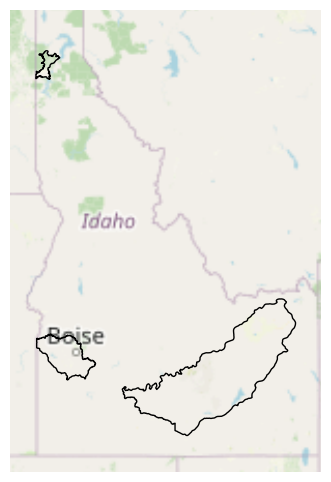

In [7]:
# Convert dataframe -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru0 = dfru0[dfru0['Geometry'] != ""].reset_index(drop=True)
dfru0['Geometry'] = gpd.GeoSeries.from_wkt(dfru0['Geometry'], crs="EPSG:4326")
gdfru0 = gpd.GeoDataFrame(dfru0, geometry=dfru0['Geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(gdfru0, ax=ax)

In [8]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe

dfs0 = dfs.copy()
nameOfWaterSourceTypeCV= "Groundwater" # change here for WaterSourceTypeCV of interest
dfs0 = dfs0[dfs0['WaterSourceTypeCV'] == nameOfWaterSourceTypeCV]
dfs0 = dfs0[dfs0['PODorPOUSite'] == 'POD']
print(len(dfs0))
print(dfs0['WaterSourceTypeCV'].unique())
dfs0.head(1)

134908
['Groundwater']


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,IDwr_SPOD10001,NaN,IDwr_WSwadeID1,WaDE Unspecified,QQQ,WaDE Unspecified,4326,NaN,NaN,NaN,NaN,46.78678,-116.75633,NaN,NaN,POD,WaDE Unspecified,POD10001,NaN,WaDE Unspecified,ID,NaN,IDwr_WSwadeID1,Groundwater


<GeoAxesSubplot: >

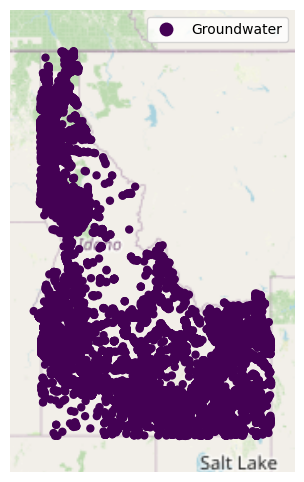

In [9]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs0 = gpd.GeoDataFrame(dfs0, geometry=gpd.points_from_xy(dfs0.Longitude.astype(float), dfs0.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs0, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [10]:
# Select sites within polygon.
gdfs0_ru0 = gpd.sjoin(left_df=gdfs0, right_df=gdfru0[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs0_ru0))
gdfs0_ru0.head()

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


72441


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
3,IDwr_SPOD100116,,IDwr_WSwadeID1,WaDE Unspecified,Digitized,WaDE Unspecified,4326,,,,,43.20912,-112.32591,,,POD,WaDE Unspecified,POD100116,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater,POINT (-112.32591 43.20912),0,IDre_RUwadeEasternSnake,IDre_ROwadeEasternSnake
7,IDwr_SPOD100156,,IDwr_WSwadeID1,WaDE Unspecified,QQ,WaDE Unspecified,4326,,,,,42.77748,-114.92504,,,POD,WaDE Unspecified,POD100156,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater,POINT (-114.92504 42.77748),0,IDre_RUwadeEasternSnake,IDre_ROwadeEasternSnake
34,IDwr_SPOD100408,,IDwr_WSwadeID1,WaDE Unspecified,QQ,WaDE Unspecified,4326,,,,,43.83951,-112.33379,,,POD,WaDE Unspecified,POD100408,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater,POINT (-112.33379 43.83951),0,IDre_RUwadeEasternSnake,IDre_ROwadeEasternSnake
35,IDwr_SPOD100415,,IDwr_WSwadeID1,WaDE Unspecified,Digitized,WaDE Unspecified,4326,,,,,42.88440,-112.88605,,,POD,WaDE Unspecified,POD100415,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater,POINT (-112.88605 42.88440),0,IDre_RUwadeEasternSnake,IDre_ROwadeEasternSnake
36,IDwr_SPOD100425,,IDwr_WSwadeID1,WaDE Unspecified,GPS - Downloaded,WaDE Unspecified,4326,,,,,42.75278,-114.77182,,,POD,WaDE Unspecified,POD100425,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater,POINT (-114.77182 42.75278),0,IDre_RUwadeEasternSnake,IDre_ROwadeEasternSnake


<GeoAxesSubplot: >

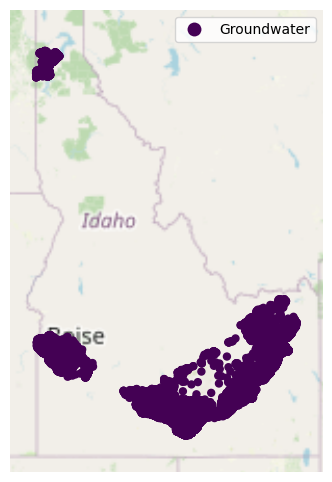

In [11]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gplt.pointplot(gdfs0_ru0, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [12]:
# set RegulatoryOverlayUUIDs
gdfs0_ru0['RegulatoryOverlayUUIDs'] = gdfs0_ru0['RegulatoryOverlayUUID']
gdfs0_ru0 = gdfs0_ru0.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs0_ru0.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
3,IDwr_SPOD100116,IDre_ROwadeEasternSnake,IDwr_WSwadeID1,WaDE Unspecified,Digitized,WaDE Unspecified,4326,,,,,43.20912,-112.32591,,,POD,WaDE Unspecified,POD100116,,WaDE Unspecified,ID,


#### Regulatory Area Data - Groundwater Districts

In [13]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV

dfru1 = dfru.copy()
nameOfReportingUnitTypeVar = "Groundwater Districts" # change here for ReportingUnitTypeCV of interest
dfru1 = dfru1[dfru1['ReportingUnitTypeCV'] == nameOfReportingUnitTypeVar]
print(len(dfru1))
print(dfru1['WaterSourceTypeCV'].unique())
dfru1.head(1)

13
['Groundwater']


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
2,IDre_RUwadeGD1,4326,Aberdeen-American Falls Ground Water District,wadeGD1,NaN,Groundwater Districts,NaN,ID,POLYGON ((-113.00753494940288 43.1542972978970...,IDre_ROwadeGD1,Groundwater


<GeoAxesSubplot: >

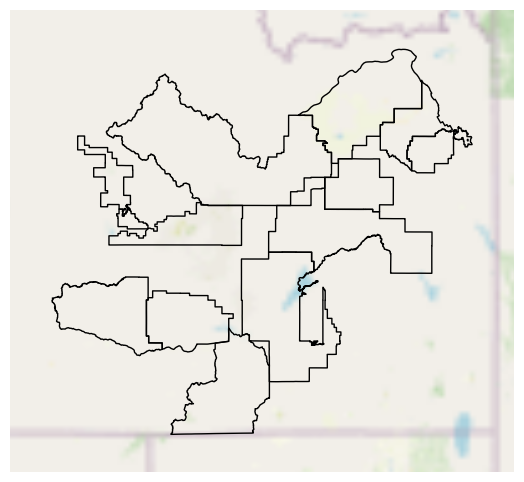

In [14]:
# Convert dataframe -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru1 = dfru1[dfru1['Geometry'] != ""].reset_index(drop=True)
dfru1['Geometry'] = gpd.GeoSeries.from_wkt(dfru1['Geometry'], crs="EPSG:4326")
gdfru1 = gpd.GeoDataFrame(dfru1, geometry=dfru1['Geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(gdfru1, ax=ax)

In [15]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe

dfs1 = dfs.copy()
nameOfWaterSourceTypeCV= "Groundwater" # change here for WaterSourceTypeCV of interest
dfs1 = dfs1[dfs1['WaterSourceTypeCV'] == nameOfWaterSourceTypeCV]
dfs1 = dfs1[dfs1['PODorPOUSite'] == 'POD']
print(len(dfs1))
print(dfs1['WaterSourceTypeCV'].unique())
dfs1.head(1)

134908
['Groundwater']


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,IDwr_SPOD10001,NaN,IDwr_WSwadeID1,WaDE Unspecified,QQQ,WaDE Unspecified,4326,NaN,NaN,NaN,NaN,46.78678,-116.75633,NaN,NaN,POD,WaDE Unspecified,POD10001,NaN,WaDE Unspecified,ID,NaN,IDwr_WSwadeID1,Groundwater


<GeoAxesSubplot: >

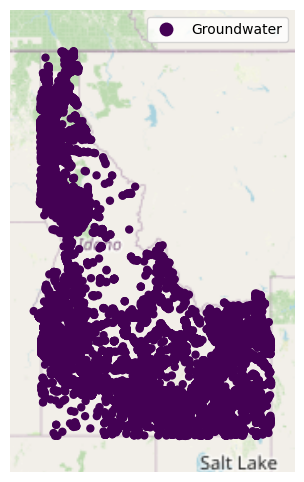

In [16]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs1 = gpd.GeoDataFrame(dfs1, geometry=gpd.points_from_xy(dfs1.Longitude.astype(float), dfs1.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [17]:
# Select sites within polygon.
gdfs1_ru1 = gpd.sjoin(left_df=gdfs1, right_df=gdfru1[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs1_ru1))
gdfs1_ru1.head()

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


48386


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
3,IDwr_SPOD100116,,IDwr_WSwadeID1,WaDE Unspecified,Digitized,WaDE Unspecified,4326,,,,,43.20912,-112.32591,,,POD,WaDE Unspecified,POD100116,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater,POINT (-112.32591 43.20912),2,IDre_RUwadeGD11,IDre_ROwadeGD11
94,IDwr_SPOD100861,,IDwr_WSwadeID1,WaDE Unspecified,GPS - Downloaded,WaDE Unspecified,4326,,,,,43.41806,-112.13366,,,POD,Woodville Well #3,POD100861,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater,POINT (-112.13366 43.41806),2,IDre_RUwadeGD11,IDre_ROwadeGD11
95,IDwr_SPOD100862,,IDwr_WSwadeID1,WaDE Unspecified,GPS - Downloaded,WaDE Unspecified,4326,,,,,43.41492,-112.13482,,,POD,Woodville Well #1,POD100862,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater,POINT (-112.13482 43.41492),2,IDre_RUwadeGD11,IDre_ROwadeGD11
100,IDwr_SPOD100886,,IDwr_WSwadeID1,WaDE Unspecified,Digitized,WaDE Unspecified,4326,,,,,43.19453,-112.47977,,,POD,358609,POD100886,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater,POINT (-112.47977 43.19453),2,IDre_RUwadeGD11,IDre_ROwadeGD11
107,IDwr_SPOD100911,,IDwr_WSwadeID1,WaDE Unspecified,Digitized,WaDE Unspecified,4326,,,,,43.19453,-112.47977,,,POD,358609,POD100911,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater,POINT (-112.47977 43.19453),2,IDre_RUwadeGD11,IDre_ROwadeGD11


<GeoAxesSubplot: >

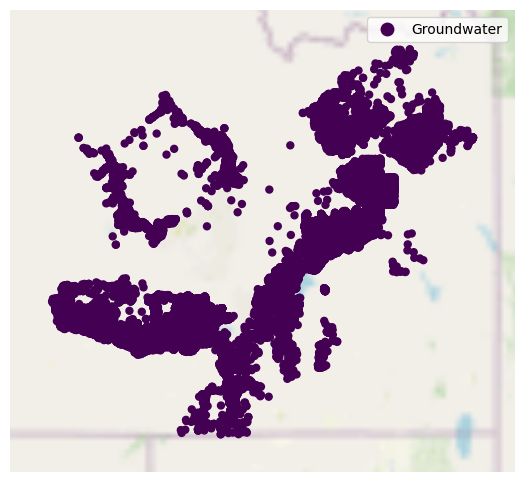

In [18]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gplt.pointplot(gdfs1_ru1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [19]:
# set RegulatoryOverlayUUIDs
gdfs1_ru1['RegulatoryOverlayUUIDs'] = gdfs1_ru1['RegulatoryOverlayUUID']
gdfs1_ru1 = gdfs1_ru1.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs1_ru1.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
3,IDwr_SPOD100116,IDre_ROwadeGD11,IDwr_WSwadeID1,WaDE Unspecified,Digitized,WaDE Unspecified,4326,,,,,43.20912,-112.32591,,,POD,WaDE Unspecified,POD100116,,WaDE Unspecified,ID,


#### Regulatory Area Data - Groundwater Management Areas

In [20]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV

dfru2 = dfru.copy()
nameOfReportingUnitTypeVar2 = "Groundwater Management Areas" # change here for ReportingUnitTypeCV of interest
dfru2 = dfru2[dfru2['ReportingUnitTypeCV'] == nameOfReportingUnitTypeVar2]
print(len(dfru2))
print(dfru2['WaterSourceTypeCV'].unique())
dfru2.head(1)

14
['Groundwater']


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
15,IDre_RUwadeGMA1,4326,Banbury Hot Springs,wadeGMA1,NaN,Groundwater Management Areas,4/27/2023,ID,POLYGON ((-114.84727118448886 42.7250076989836...,IDre_ROwadeGMA1,Groundwater


<GeoAxesSubplot: >

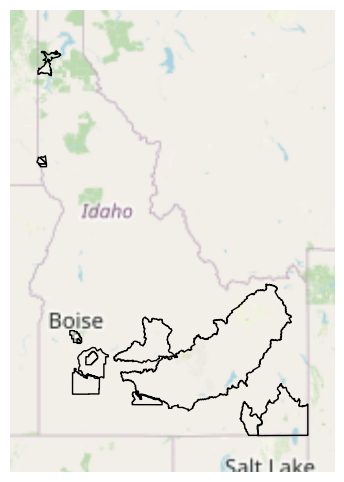

In [21]:
# Convert dataframe -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru2 = dfru2[dfru2['Geometry'] != ""].reset_index(drop=True)
dfru2['Geometry'] = gpd.GeoSeries.from_wkt(dfru2['Geometry'], crs="EPSG:4326")
gdfru2 = gpd.GeoDataFrame(dfru2, geometry=dfru2['Geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(gdfru2, ax=ax)

In [22]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe

dfs2 = dfs.copy()
nameOfWaterSourceTypeCV2= "Groundwater" # change here for WaterSourceTypeCV of interest
dfs2 = dfs2[dfs2['WaterSourceTypeCV'] == nameOfWaterSourceTypeCV2]
dfs2 = dfs2[dfs2['PODorPOUSite'] == 'POD']
print(len(dfs2))
print(dfs2['WaterSourceTypeCV'].unique())
dfs2.head(1)

134908
['Groundwater']


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,IDwr_SPOD10001,NaN,IDwr_WSwadeID1,WaDE Unspecified,QQQ,WaDE Unspecified,4326,NaN,NaN,NaN,NaN,46.78678,-116.75633,NaN,NaN,POD,WaDE Unspecified,POD10001,NaN,WaDE Unspecified,ID,NaN,IDwr_WSwadeID1,Groundwater


<GeoAxesSubplot: >

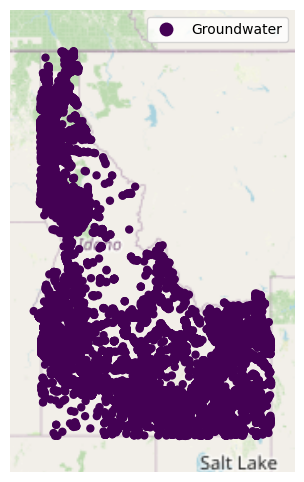

In [23]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs2 = gpd.GeoDataFrame(dfs2, geometry=gpd.points_from_xy(dfs2.Longitude.astype(float), dfs1.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs2, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [24]:
# Select sites within polygon.
gdfs2_ru2 = gpd.sjoin(left_df=gdfs2, right_df=gdfru2[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs2_ru2))
gdfs2_ru2.head()

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


65375


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
3,IDwr_SPOD100116,,IDwr_WSwadeID1,WaDE Unspecified,Digitized,WaDE Unspecified,4326,,,,,43.20912,-112.32591,,,POD,WaDE Unspecified,POD100116,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater,POINT (-112.32591 43.20912),10,IDre_RUwadeGMA6,IDre_ROwadeGMA6
34,IDwr_SPOD100408,,IDwr_WSwadeID1,WaDE Unspecified,QQ,WaDE Unspecified,4326,,,,,43.83951,-112.33379,,,POD,WaDE Unspecified,POD100408,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater,POINT (-112.33379 43.83951),10,IDre_RUwadeGMA6,IDre_ROwadeGMA6
35,IDwr_SPOD100415,,IDwr_WSwadeID1,WaDE Unspecified,Digitized,WaDE Unspecified,4326,,,,,42.88440,-112.88605,,,POD,WaDE Unspecified,POD100415,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater,POINT (-112.88605 42.88440),10,IDre_RUwadeGMA6,IDre_ROwadeGMA6
36,IDwr_SPOD100425,,IDwr_WSwadeID1,WaDE Unspecified,GPS - Downloaded,WaDE Unspecified,4326,,,,,42.75278,-114.77182,,,POD,WaDE Unspecified,POD100425,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater,POINT (-114.77182 42.75278),10,IDre_RUwadeGMA6,IDre_ROwadeGMA6
40,IDwr_SPOD100518,,IDwr_WSwadeID1,WaDE Unspecified,QQ,WaDE Unspecified,4326,,,,,43.45184,-112.08586,,,POD,WaDE Unspecified,POD100518,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater,POINT (-112.08586 43.45184),10,IDre_RUwadeGMA6,IDre_ROwadeGMA6


<GeoAxesSubplot: >

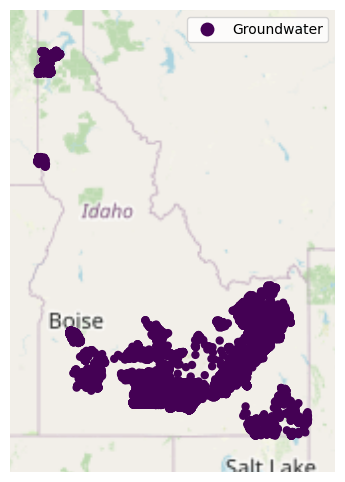

In [25]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gplt.pointplot(gdfs2_ru2, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [26]:
# set RegulatoryOverlayUUIDs
gdfs2_ru2['RegulatoryOverlayUUIDs'] = gdfs2_ru2['RegulatoryOverlayUUID']
gdfs2_ru2 = gdfs2_ru2.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs2_ru2.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
3,IDwr_SPOD100116,IDre_ROwadeGMA6,IDwr_WSwadeID1,WaDE Unspecified,Digitized,WaDE Unspecified,4326,,,,,43.20912,-112.32591,,,POD,WaDE Unspecified,POD100116,,WaDE Unspecified,ID,


#### Regulatory Area Data - Aquifer Recharge District

In [27]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV

dfru3 = dfru.copy()
nameOfReportingUnitTypeVar3 = "Aquifer Recharge Districts" # change here for ReportingUnitTypeCV of interest
dfru3 = dfru3[dfru3['ReportingUnitTypeCV'] == nameOfReportingUnitTypeVar3]
print(len(dfru3))
print(dfru3['WaterSourceTypeCV'].unique())
dfru3.head(1)

1
['Groundwater']


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
0,IDre_RUwadeARD1,4326,Lower Snake River Aquifer Recharge District,wadeARD1,NaN,Aquifer Recharge Districts,4/27/2023,ID,POLYGON ((-114.45343337104535 42.6049368772191...,IDre_ROwadeARD1,Groundwater


<GeoAxesSubplot: >

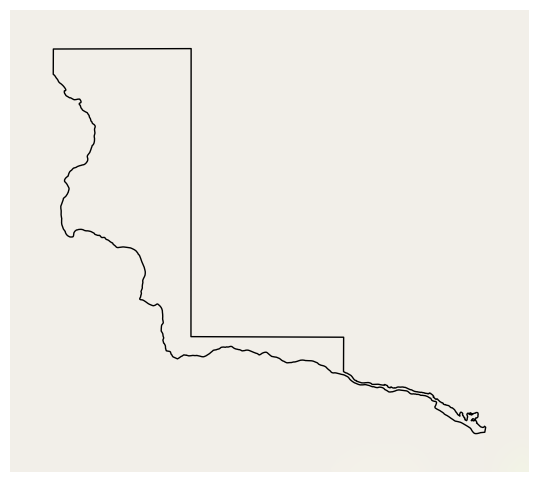

In [28]:
# Convert dataframe -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru3 = dfru3[dfru3['Geometry'] != ""].reset_index(drop=True)
dfru3['Geometry'] = gpd.GeoSeries.from_wkt(dfru3['Geometry'], crs="EPSG:4326")
gdfru3 = gpd.GeoDataFrame(dfru3, geometry=dfru3['Geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(gdfru3, ax=ax)

In [29]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe

dfs3 = dfs.copy()
nameOfWaterSourceTypeCV3= "Groundwater" # change here for WaterSourceTypeCV of interest
dfs3 = dfs3[dfs3['WaterSourceTypeCV'] == nameOfWaterSourceTypeCV3]
dfs3 = dfs3[dfs3['PODorPOUSite'] == 'POD']
print(len(dfs3))
print(dfs3['WaterSourceTypeCV'].unique())
dfs3.head(1)

134908
['Groundwater']


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,IDwr_SPOD10001,NaN,IDwr_WSwadeID1,WaDE Unspecified,QQQ,WaDE Unspecified,4326,NaN,NaN,NaN,NaN,46.78678,-116.75633,NaN,NaN,POD,WaDE Unspecified,POD10001,NaN,WaDE Unspecified,ID,NaN,IDwr_WSwadeID1,Groundwater


<GeoAxesSubplot: >

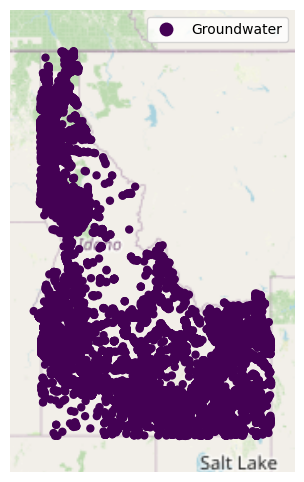

In [30]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs3 = gpd.GeoDataFrame(dfs3, geometry=gpd.points_from_xy(dfs3.Longitude.astype(float), dfs1.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs3, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [31]:
# Select sites within polygon.
gdfs3_ru3 = gpd.sjoin(left_df=gdfs3, right_df=gdfru3[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs3_ru3))
gdfs3_ru3.head()

786


C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
7,IDwr_SPOD100156,,IDwr_WSwadeID1,WaDE Unspecified,QQ,WaDE Unspecified,4326,,,,,42.77748,-114.92504,,,POD,WaDE Unspecified,POD100156,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater,POINT (-114.92504 42.77748),0,IDre_RUwadeARD1,IDre_ROwadeARD1
6786,IDwr_SPOD231467,,IDwr_WSwadeID1,WaDE Unspecified,GPS - Downloaded,WaDE Unspecified,4326,,,,,42.66596,-114.63185,,,POD,WaDE Unspecified,POD231467,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater,POINT (-114.63185 42.66596),0,IDre_RUwadeARD1,IDre_ROwadeARD1
6787,IDwr_SPOD231468,,IDwr_WSwadeID1,WaDE Unspecified,GPS - Downloaded,WaDE Unspecified,4326,,,,,42.67023,-114.62896,,,POD,WaDE Unspecified,POD231468,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater,POINT (-114.62896 42.67023),0,IDre_RUwadeARD1,IDre_ROwadeARD1
6795,IDwr_SPOD231475,,IDwr_WSwadeID1,WaDE Unspecified,GPS - Downloaded,WaDE Unspecified,4326,,,,,42.72495,-114.81666,,,POD,Sand Springs #1,POD231475,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater,POINT (-114.81666 42.72495),0,IDre_RUwadeARD1,IDre_ROwadeARD1
6817,IDwr_SPOD231500,,IDwr_WSwadeID1,WaDE Unspecified,GPS - Downloaded,WaDE Unspecified,4326,,,,,42.72495,-114.81666,,,POD,Sand Springs #1,POD231500,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater,POINT (-114.81666 42.72495),0,IDre_RUwadeARD1,IDre_ROwadeARD1


<GeoAxesSubplot: >

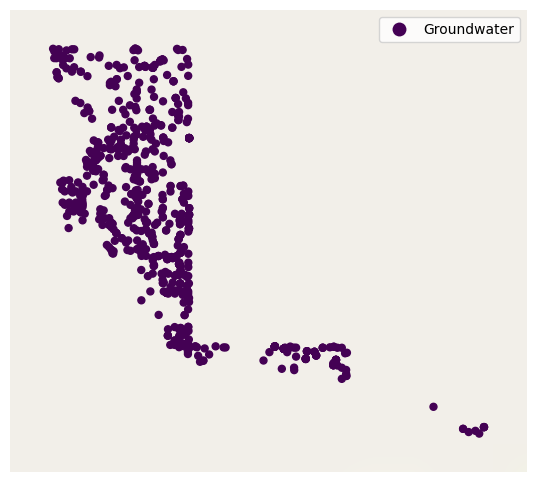

In [32]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gplt.pointplot(gdfs3_ru3, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [33]:
# set RegulatoryOverlayUUIDs
gdfs3_ru3['RegulatoryOverlayUUIDs'] = gdfs3_ru3['RegulatoryOverlayUUID']
gdfs3_ru3 = gdfs3_ru3.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs3_ru3.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
7,IDwr_SPOD100156,IDre_ROwadeARD1,IDwr_WSwadeID1,WaDE Unspecified,QQ,WaDE Unspecified,4326,,,,,42.77748,-114.92504,,,POD,WaDE Unspecified,POD100156,,WaDE Unspecified,ID,


## Concatenate all Regulatory Area Data Types together
- drop geometry from the wade wr sites.csv geodataframe

In [34]:
# Concatenate dataframes into single output
frames = [dfs, gdfs0_ru0, gdfs1_ru1, gdfs2_ru2, gdfs3_ru3] # list all out dataframes here
outdfs = pd.concat(frames)
outdfs = outdfs.drop_duplicates().reset_index(drop=True).replace(np.nan, "")
outdfs = outdfs.groupby('SiteUUID').agg(lambda x: ','.join([str(elem) for elem in (list(set(x))) if elem != ""])).replace(np.nan, "").reset_index()
print(len(outdfs))
outdfs.head(1)

463609


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,IDwr_SPOD10001,,IDwr_WSwadeID1,WaDE Unspecified,QQQ,WaDE Unspecified,4326,,,,,46.786783431,-116.756334953,,,POD,WaDE Unspecified,POD10001,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater


# Inspect Output Data & Export

In [35]:
outdfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463609 entries, 0 to 463608
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   SiteUUID                463609 non-null  object
 1   RegulatoryOverlayUUIDs  463609 non-null  object
 2   WaterSourceUUIDs        463609 non-null  object
 3   CoordinateAccuracy      463609 non-null  object
 4   CoordinateMethodCV      463609 non-null  object
 5   County                  463609 non-null  object
 6   EPSGCodeCV              463609 non-null  object
 7   Geometry                463609 non-null  object
 8   GNISCodeCV              463609 non-null  object
 9   HUC12                   463609 non-null  object
 10  HUC8                    463609 non-null  object
 11  Latitude                463609 non-null  object
 12  Longitude               463609 non-null  object
 13  NHDNetworkStatusCV      463609 non-null  object
 14  NHDProductCV            463609 non-n

In [36]:
outdfs

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,IDwr_SPOD10001,,IDwr_WSwadeID1,WaDE Unspecified,QQQ,WaDE Unspecified,4326,,,,,46.786783431,-116.756334953,,,POD,WaDE Unspecified,POD10001,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater
1,IDwr_SPOD10002,,IDwr_WSwadeID2,WaDE Unspecified,QQQ,WaDE Unspecified,4326,,,,,46.620745726,-116.678043708,,,POD,WaDE Unspecified,POD10002,,WaDE Unspecified,ID,,IDwr_WSwadeID2,Surface Water
2,IDwr_SPOD10011,,IDwr_WSwadeID464,WaDE Unspecified,Digitized,WaDE Unspecified,4326,,,,,48.619278353,-116.411597116,,,POD,Ascentnorthwest Academy Ruby Creek,POD10011,,WaDE Unspecified,ID,,IDwr_WSwadeID464,Surface Water
3,IDwr_SPOD100116,"IDre_ROwadeEasternSnake,IDre_ROwadeGD11,IDre_R...",IDwr_WSwadeID1,WaDE Unspecified,Digitized,WaDE Unspecified,4326,,,,,43.209117477,-112.325906615,,,POD,WaDE Unspecified,POD100116,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater
4,IDwr_SPOD10012,,IDwr_WSwadeID2,WaDE Unspecified,Digitized,WaDE Unspecified,4326,,,,,48.619278353,-116.411597116,,,POD,Ascentnorthwest Academy Ruby Creek,POD10012,,WaDE Unspecified,ID,,IDwr_WSwadeID2,Surface Water
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463604,IDwr_SPOU99984,,IDwr_WSwadeID1071,WaDE Unspecified,Centroid,WaDE Unspecified,4326,POLYGON ((-113.83349343399999 43.3785455800000...,,,,43.3768924284,-113.831084803,,,POU,WaDE Unspecified,POU99984,,WaDE Unspecified,ID,,IDwr_WSwadeID1071,Surface Water
463605,IDwr_SPOU99985,,IDwr_WSwadeID4,WaDE Unspecified,Centroid,WaDE Unspecified,4326,POLYGON ((-113.76915873299998 43.3895130230000...,,,,43.3930982896,-113.766591765,,,POU,WaDE Unspecified,POU99985,,WaDE Unspecified,ID,,IDwr_WSwadeID4,Surface Water
463606,IDwr_SPOU99987,,IDwr_WSwadeID1239,WaDE Unspecified,Centroid,WaDE Unspecified,4326,POLYGON ((-114.17487861799998 43.9047213540000...,,,,43.9046611773,-114.175966206,,,POU,WaDE Unspecified,POU99987,,WaDE Unspecified,ID,,IDwr_WSwadeID1239,Surface Water
463607,IDwr_SPOU9999,,IDwr_WSwadeID1,WaDE Unspecified,Centroid,WaDE Unspecified,4326,POLYGON ((-112.39023373799995 42.7510759940000...,,,,42.752865087,-112.392685561,,,POU,WaDE Unspecified,POU9999,,WaDE Unspecified,ID,,IDwr_WSwadeID1,Groundwater


In [37]:
# Export out to CSV.
outdfs.to_csv('ProcessedInputData/sites.csv', index=False) # this is in the Regulatory data folder